In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from scipy.stats import uniform, randint
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

/Users/cary/anaconda3/envs/ML/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
tp_bound = 111994
predict_max_index = 185223

In [3]:
training_data_df = pd.read_csv('training_data.csv', index_col = [0])
predict_data_df = pd.read_csv('predict_data.csv', index_col = [0])

In [4]:
# rid of N/A values and 0 values and outliers???
training_data_df = training_data_df.dropna()
training_data_df = training_data_df.drop(training_data_df[training_data_df['Gender'] == '0'].index)
training_data_df = training_data_df.drop(training_data_df[training_data_df['University Degree'] == '0'].index)
training_data_df = training_data_df.drop(training_data_df[training_data_df['Hair Color'] == '0'].index)
training_data_df = training_data_df.drop(training_data_df[training_data_df['Income'] > 2000000].index)
training_data_df = training_data_df.drop(training_data_df[training_data_df['Income'] <= 0 ].index)
training_data_df = training_data_df.drop(training_data_df[training_data_df['Body Height [cm]'] < 100].index)
training_data_df = training_data_df.drop(training_data_df[training_data_df['Body Height [cm]'] > 250].index)

training_data_df['Income'] = training_data_df['Income'].map(lambda inc: np.sqrt(np.abs(inc)))

training_data_df.shape

(89048, 11)

In [5]:
(train_bound, col) = training_data_df.shape
training_data_df.head()

,Year of Record,Gender,Age,Country,Size of City,Profession,University Degree,Wears Glasses,Hair Color,Body Height [cm],Income
Instance,,,,,,,,,,,
2,1996.0,other,41.0,Singapore,1603504,safe event coordinator,Master,0,Black,186,301.664263
3,2018.0,other,28.0,Norway,1298017,receivables/payables analyst,PhD,1,Brown,170,397.469718
4,2006.0,other,33.0,Cuba,751903,fleet assistant,No,1,Black,171,214.461554
6,1991.0,male,60.0,Liberia,56080,senior security analyst,Bachelor,0,Blond,181,354.697040
9,2015.0,male,43.0,South Sudan,85333,intergovernmental outreach coordinator,No,0,Blond,189,219.221819


In [6]:
total_data_df = pd.concat([training_data_df, predict_data_df])
total_data_df.head()

,Year of Record,Gender,Age,Country,Size of City,Profession,University Degree,Wears Glasses,Hair Color,Body Height [cm],Income
Instance,,,,,,,,,,,
2,1996.0,other,41.0,Singapore,1603504,safe event coordinator,Master,0,Black,186,301.664263
3,2018.0,other,28.0,Norway,1298017,receivables/payables analyst,PhD,1,Brown,170,397.469718
4,2006.0,other,33.0,Cuba,751903,fleet assistant,No,1,Black,171,214.461554
6,1991.0,male,60.0,Liberia,56080,senior security analyst,Bachelor,0,Blond,181,354.697040
9,2015.0,male,43.0,South Sudan,85333,intergovernmental outreach coordinator,No,0,Blond,189,219.221819


In [7]:
# column N/A values
total_data_df.shape[0] - total_data_df.count()

Year of Record         295
Gender                4862
Age                    279
Country                  0
Size of City             0
Profession             195
University Degree     4857
Wears Glasses            0
Hair Color            4916
Body Height [cm]         0
Income               73230
dtype: int64

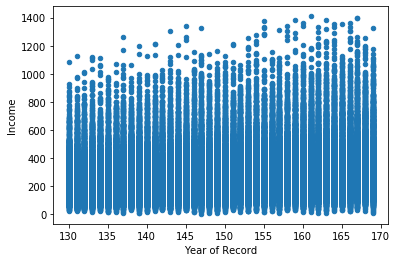

In [8]:
total_data_df['Year of Record'].fillna(2000, inplace = True)
total_data_df['Year of Record'] = total_data_df['Year of Record'].map(lambda year: year - 1850)

total_data_df[:train_bound].plot.scatter(x='Year of Record', y = 'Income')

In [9]:
total_data_df['Gender'].fillna('unknown', inplace = True)
total_data_df['Gender'].replace('0', 'unknown', inplace = True)

total_data_df['Gender'].value_counts().sort_index()

female     40955
male       65017
other      40804
unknown    15502
Name: Gender, dtype: int64

In [10]:
gender_dummies = pd.get_dummies(total_data_df['Gender'], prefix = 'Gender')
total_data_df.drop('Gender', axis = 1, inplace = True)
total_data_df = total_data_df.join(gender_dummies)
total_data_df.drop('Gender_unknown', axis = 1, inplace = True)

total_data_df.head()

,Year of Record,Age,Country,Size of City,Profession,University Degree,Wears Glasses,Hair Color,Body Height [cm],Income,Gender_female,Gender_male,Gender_other
Instance,,,,,,,,,,,,,
2,146.0,41.0,Singapore,1603504,safe event coordinator,Master,0,Black,186,301.664263,0,0,1
3,168.0,28.0,Norway,1298017,receivables/payables analyst,PhD,1,Brown,170,397.469718,0,0,1
4,156.0,33.0,Cuba,751903,fleet assistant,No,1,Black,171,214.461554,0,0,1
6,141.0,60.0,Liberia,56080,senior security analyst,Bachelor,0,Blond,181,354.697040,0,1,0
9,165.0,43.0,South Sudan,85333,intergovernmental outreach coordinator,No,0,Blond,189,219.221819,0,1,0


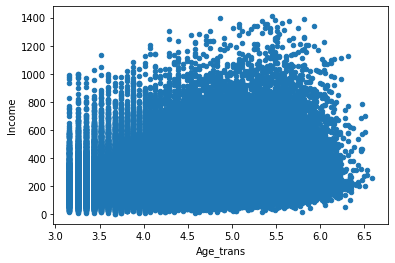

In [11]:
# total_data_df['Age'].fillna(35, inplace=True)
# total_data_df['AgeSqrt'] = total_data_df['Age'].map(lambda a: np.sqrt(a))
# total_data_df.drop('Age', axis = 1, inplace = True)
# total_data_df[:train_bound].plot.scatter(x='AgeSqrt', y = 'Income')

total_data_df['Age'].fillna(35, inplace=True)

trans = preprocessing.PowerTransformer(method='box-cox', standardize=False)
total_data_df['Age_trans'] = trans.fit_transform(total_data_df[['Age']])
total_data_df.drop('Age', axis = 1, inplace = True)

total_data_df[:train_bound].plot.scatter(x='Age_trans', y = 'Income')


In [12]:
total_data_df['Country'].fillna('unknown', inplace = True)
dummies = pd.get_dummies(total_data_df['Country'], prefix = 'Country')
total_data_df.drop('Country', axis = 1, inplace = True)
total_data_df = total_data_df.join(dummies)

total_data_df.head()

,Year of Record,Size of City,Profession,University Degree,Wears Glasses,Hair Color,Body Height [cm],Income,Gender_female,Gender_male,...,Country_Ukraine,Country_United Arab Emirates,Country_United Kingdom,Country_Uruguay,Country_Uzbekistan,Country_Vanuatu,Country_Venezuela,Country_Yemen,Country_Zambia,Country_Zimbabwe
Instance,,,,,,,,,,,,,,,,,,,,,
2,146.0,1603504,safe event coordinator,Master,0,Black,186,301.664263,0,0,...,0,0,0,0,0,0,0,0,0,0
3,168.0,1298017,receivables/payables analyst,PhD,1,Brown,170,397.469718,0,0,...,0,0,0,0,0,0,0,0,0,0
4,156.0,751903,fleet assistant,No,1,Black,171,214.461554,0,0,...,0,0,0,0,0,0,0,0,0,0
6,141.0,56080,senior security analyst,Bachelor,0,Blond,181,354.697040,0,1,...,0,0,0,0,0,0,0,0,0,0
9,165.0,85333,intergovernmental outreach coordinator,No,0,Blond,189,219.221819,0,1,...,0,0,0,0,0,0,0,0,0,0


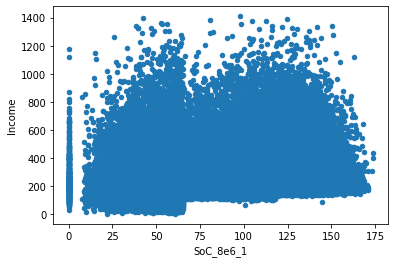

In [13]:
total_data_df['SoC_8e6_1'] = total_data_df['Size of City'].map(lambda soc: soc if soc < 8e6 else 0.1)
total_data_df['SoC_8e6_2'] = total_data_df['Size of City'].map(lambda soc: soc if soc > 8e6 else 0.1)
total_data_df.drop('Size of City', axis = 1, inplace = True)

trans = preprocessing.PowerTransformer(method='yeo-johnson', standardize=False)
total_data_df['SoC_8e6_1'] = trans.fit_transform(total_data_df[['SoC_8e6_1']])

total_data_df[:train_bound].plot.scatter(x='SoC_8e6_1', y = 'Income')

In [14]:
total_data_df['Profession'].fillna('unknown', inplace = True)
dummies = pd.get_dummies(total_data_df['Profession'], prefix = 'P')
total_data_df.drop('Profession', axis = 1, inplace = True)
total_data_df = total_data_df.join(dummies)
total_data_df.drop('P_unknown', axis = 1, inplace = True)

total_data_df.head()

,Year of Record,University Degree,Wears Glasses,Hair Color,Body Height [cm],Income,Gender_female,Gender_male,Gender_other,Age_trans,...,P_windows administrator,P_wireless coordinator,P_woodworker,P_word processor,P_workforce management analyst,P_workforce planning intern,P_writer,P_x-ray technician,P_yardmaster,P_youth initiatives lead advisor
Instance,,,,,,,,,,,,,,,,,,,,,
2,146.0,Master,0,Black,186,301.664263,0,0,1,4.792236,...,0,0,0,0,0,0,0,0,0,0
3,168.0,PhD,1,Brown,170,397.469718,0,0,1,4.185107,...,0,0,0,0,0,0,0,0,0,0
4,156.0,No,1,Black,171,214.461554,0,0,1,4.442932,...,0,0,0,0,0,0,0,0,0,0
6,141.0,Bachelor,0,Blond,181,354.697040,0,1,0,5.429679,...,0,0,0,0,0,0,0,0,0,0
9,165.0,No,0,Blond,189,219.221819,0,1,0,4.870227,...,0,0,0,0,0,0,0,0,0,0


In [15]:
total_data_df['University Degree'].fillna('unknown', inplace = True)
total_data_df['University Degree'].replace('0', 'unknown', inplace = True)
dummies = pd.get_dummies(total_data_df['University Degree'], prefix = 'UD')
total_data_df.drop('University Degree', axis = 1, inplace = True)
total_data_df = total_data_df.join(dummies)
total_data_df.drop('UD_unknown', axis = 1, inplace = True)

total_data_df.head()

,Year of Record,Wears Glasses,Hair Color,Body Height [cm],Income,Gender_female,Gender_male,Gender_other,Age_trans,Country_Afghanistan,...,P_workforce management analyst,P_workforce planning intern,P_writer,P_x-ray technician,P_yardmaster,P_youth initiatives lead advisor,UD_Bachelor,UD_Master,UD_No,UD_PhD
Instance,,,,,,,,,,,,,,,,,,,,,
2,146.0,0,Black,186,301.664263,0,0,1,4.792236,0,...,0,0,0,0,0,0,0,1,0,0
3,168.0,1,Brown,170,397.469718,0,0,1,4.185107,0,...,0,0,0,0,0,0,0,0,0,1
4,156.0,1,Black,171,214.461554,0,0,1,4.442932,0,...,0,0,0,0,0,0,0,0,1,0
6,141.0,0,Blond,181,354.697040,0,1,0,5.429679,0,...,0,0,0,0,0,0,1,0,0,0
9,165.0,0,Blond,189,219.221819,0,1,0,4.870227,0,...,0,0,0,0,0,0,0,0,1,0


In [16]:
# dummies = pd.get_dummies(total_data_df['Wears Glasses'], prefix = 'WG')
# total_data_df.drop('Wears Glasses', axis = 1, inplace = True)
# total_data_df = total_data_df.join(dummies)

# drop glasses
total_data_df.drop('Wears Glasses', axis = 1, inplace = True)

total_data_df.head()

,Year of Record,Hair Color,Body Height [cm],Income,Gender_female,Gender_male,Gender_other,Age_trans,Country_Afghanistan,Country_Albania,...,P_workforce management analyst,P_workforce planning intern,P_writer,P_x-ray technician,P_yardmaster,P_youth initiatives lead advisor,UD_Bachelor,UD_Master,UD_No,UD_PhD
Instance,,,,,,,,,,,,,,,,,,,,,
2,146.0,Black,186,301.664263,0,0,1,4.792236,0,0,...,0,0,0,0,0,0,0,1,0,0
3,168.0,Brown,170,397.469718,0,0,1,4.185107,0,0,...,0,0,0,0,0,0,0,0,0,1
4,156.0,Black,171,214.461554,0,0,1,4.442932,0,0,...,0,0,0,0,0,0,0,0,1,0
6,141.0,Blond,181,354.697040,0,1,0,5.429679,0,0,...,0,0,0,0,0,0,1,0,0,0
9,165.0,Blond,189,219.221819,0,1,0,4.870227,0,0,...,0,0,0,0,0,0,0,0,1,0


In [17]:
# total_data_df['Hair Color'].fillna('unknown', inplace = True)
# total_data_df['Hair Color'].replace('0', 'unknown', inplace = True)
# dummies = pd.get_dummies(total_data_df['Hair Color'], prefix = 'HC')
# total_data_df.drop('Hair Color', axis = 1, inplace = True)
# total_data_df = total_data_df.join(dummies)
# total_data_df.drop('HC_unknown', axis = 1, inplace = True)

# drop hair
total_data_df.drop('Hair Color', axis = 1, inplace = True)

total_data_df.head()

,Year of Record,Body Height [cm],Income,Gender_female,Gender_male,Gender_other,Age_trans,Country_Afghanistan,Country_Albania,Country_Algeria,...,P_workforce management analyst,P_workforce planning intern,P_writer,P_x-ray technician,P_yardmaster,P_youth initiatives lead advisor,UD_Bachelor,UD_Master,UD_No,UD_PhD
Instance,,,,,,,,,,,,,,,,,,,,,
2,146.0,186,301.664263,0,0,1,4.792236,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,168.0,170,397.469718,0,0,1,4.185107,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,156.0,171,214.461554,0,0,1,4.442932,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,141.0,181,354.697040,0,1,0,5.429679,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9,165.0,189,219.221819,0,1,0,4.870227,0,0,0,...,0,0,0,0,0,0,0,0,1,0


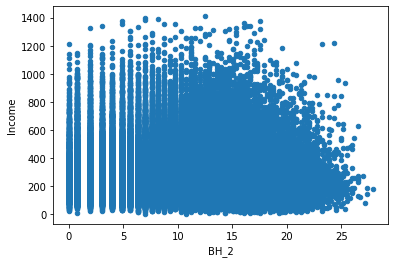

In [18]:
total_data_df['BH_2'] = total_data_df['Body Height [cm]'].map(lambda bh: (180 - bh)**2)
total_data_df.drop('Body Height [cm]', axis = 1, inplace = True)

trans = preprocessing.PowerTransformer(method='yeo-johnson', standardize=False)
total_data_df['BH_2'] = trans.fit_transform(total_data_df[['BH_2']])

total_data_df[:train_bound].plot.scatter(x='BH_2', y = 'Income')

In [32]:
total = total_data_df.drop('Income', axis = 1, inplace = False)
X = total[: train_bound]
y = total_data_df[:train_bound]['Income']

In [25]:
# training

def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# linreg1 = LinearRegression()
# rfReg = RandomForestRegressor()
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=None)

# KFlod
kfold = KFold(n_splits=20, random_state=None, shuffle=True)
results_arr = []
iii = 0
for train_index, test_index in kfold.split(X):
    print(iii, ':')
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    linreg1 = LinearRegression()
    linreg1.fit(X_train, y_train)
    score = linreg1.score(X_test, y_test)
    print(score)
    results_arr.append((linreg1, score))
    iii += 1
    
# XGBoost
# xgb_model = xgb.XGBRegressor()
# params = {
#     "colsample_bytree": uniform(0.7, 0.3),
#     "gamma": uniform(0, 0.5),
#     "learning_rate": uniform(0.03, 0.3), # default 0.1 
#     "max_depth": randint(2, 6), # default 3
#     "n_estimators": randint(100, 150), # default 100
#     "subsample": uniform(0.6, 0.4)
# }
# parameters = {'n_estimators': [120, 100, 140], 'max_depth':[3,5,7,9]}

# random search
# RSearch = RandomizedSearchCV(xgb_model,
#                              param_distributions=params,
#                              random_state=13,
#                              n_iter=200,
#                              cv=20,
#                              verbose=1,
#                              n_jobs=4,
#                              return_train_score=True)
# RSearch.fit(X.values, y.values)
# report_best_scores(RSearch.cv_results_, 1)

# grid_search = GridSearchCV(estimator=xgb_model, param_grid=parameters, cv=10, n_jobs=-1)
# grid_search.fit(X.values, y.values)
# best_parameters=grid_search.best_estimator_.get_params()
# for param_name in sorted(parameters.keys()):
#     print("\t%s: %r" % (param_name, best_parameters[param_name]))

# linreg1.fit(X_train, y_train)
# print(linreg1.score(X_test, y_test))
# y_pred = linreg1.predict(X_test)
# print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

# rfReg.fit(X_train, y_train)
# rfReg.score(X_test, y_test)

0 :
TRAIN: [    0     1     2 ... 89045 89046 89047] TEST: [    5    53    59 ... 88967 88971 88998]
0.8483230801888391
1 :
TRAIN: [    0     1     2 ... 89045 89046 89047] TEST: [   14    44    47 ... 88953 89039 89043]
0.8637837739493532
2 :
TRAIN: [    0     1     2 ... 89045 89046 89047] TEST: [   11    30    35 ... 89003 89005 89023]
0.8730743471730867
3 :
TRAIN: [    0     1     2 ... 89045 89046 89047] TEST: [   29    79   112 ... 88977 88987 89037]
0.8541476531582872
4 :
TRAIN: [    0     1     2 ... 89045 89046 89047] TEST: [   28    36   158 ... 88981 89018 89033]
0.8618474962633421
5 :
TRAIN: [    0     1     3 ... 89045 89046 89047] TEST: [    2    13    16 ... 89035 89041 89044]
0.8590523143910491
6 :
TRAIN: [    0     1     2 ... 89045 89046 89047] TEST: [   84   104   110 ... 88999 89022 89040]
0.8593330043984095
7 :
TRAIN: [    0     1     2 ... 89045 89046 89047] TEST: [    7    50    54 ... 88949 88950 89020]
0.8600866957451406
8 :
TRAIN: [    0     2     4 ... 89045 

In [37]:
# lightgbm
param = {'num_leaves': [200], 'num_trees': [600]}
gsearch = GridSearchCV(estimator=lgb.sklearn.LGBMRegressor(n_estimators=100,boosting_type='gbdt', objective='regression'),param_grid = param, scoring='neg_mean_absolute_error', cv=5,verbose = 20, n_jobs = -1)

gsearch.fit(X, y)

print(gsearch.cv_results_, gsearch.best_params_, gsearch.best_score_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1201s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

In [38]:
x = total[train_bound: ]

(linreg1, _) = results_arr[9]
y = linreg1.predict(x)
# y = rfReg.predict(x)
# y = gbm.predict(x, num_iteration=gbm.best_iteration)
# y = gsearch.best_estimator_.predict(x)

In [39]:
income_series = pd.Series(y, name = 'Income')
instance_series = pd.Series(np.arange(tp_bound, predict_max_index + 1), name = 'Instance')
result = pd.concat([instance_series, income_series], axis = 1)
result['Income'] = result['Income'].map(lambda y: y**2)
result.to_csv('result-9.csv', index = False)